In [6]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/dataset.zip

In [1]:
!pip install pretrainedmodels

     |████████████████████████████████| 61kB 7.7MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=fc54e953a11d57c50ca1883f7287e90be3d90b9f856b6e1c16ff8ebc9c0385e2
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [2]:
import os
import time
import copy
import numpy as np
import matplotlib.pyplot as plt

import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models

import pretrainedmodels.utils as utils

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
device

device(type='cuda', index=0)

In [8]:
image = plt.imread("/content/dataset_zurich/train/merger/587722952231026743.jpeg")
image.shape

(631, 631, 3)

In [9]:
import pretrainedmodels

In [10]:
pretrainedmodels.model_names

['fbresnet152',
 'bninception',
 'resnext101_32x4d',
 'resnext101_64x4d',
 'inceptionv4',
 'inceptionresnetv2',
 'alexnet',
 'densenet121',
 'densenet169',
 'densenet201',
 'densenet161',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnet101',
 'resnet152',
 'inceptionv3',
 'squeezenet1_0',
 'squeezenet1_1',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19_bn',
 'vgg19',
 'nasnetamobile',
 'nasnetalarge',
 'dpn68',
 'dpn68b',
 'dpn92',
 'dpn98',
 'dpn131',
 'dpn107',
 'xception',
 'senet154',
 'se_resnet50',
 'se_resnet101',
 'se_resnet152',
 'se_resnext50_32x4d',
 'se_resnext101_32x4d',
 'cafferesnet101',
 'pnasnet5large',
 'polynet']

In [11]:
# Import xception pre-trained model
model_name = 'xception' # could be fbresnet152 or inceptionresnetv2
model_conv = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model_conv.eval()
tf_img = utils.TransformImage(model_conv)

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/xception-43020ad28.pth" to /root/.cache/torch/hub/checkpoints/xception-43020ad28.pth


In [12]:
data_transforms = tf_img

In [13]:
data_dir = "/content/dataset_zurich"
types = ["train", "val", "test"]
transform_types = ["train", "val"]  # Do not transform the test set (since it is not learned)

batch_size = 8 # Smaller batch sizes are better for generalization to test set
shuffle = True
num_workers = 1

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in transform_types}
image_datasets["test"] = datasets.ImageFolder(os.path.join(data_dir, "test"), data_transforms)  # Do not transform test set, only load it. 

dataloaders = {x: torch.utils.data.DataLoader(
                image_datasets[x], batch_size=batch_size, shuffle=shuffle, num_workers=num_workers) for x in types
              }

dataset_sizes = {x: len(image_datasets[x]) for x in types}
class_names = image_datasets['train'].classes

In [14]:
class_names

['merger', 'noninteracting']

In [15]:
dataset_sizes

{'test': 3998, 'train': 8003, 'val': 3999}

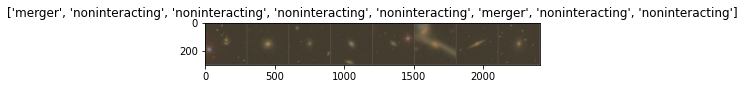

In [16]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [17]:
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [18]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [19]:
# Hyperparameters from the paper (A1. Main Experiment)
n_epochs = 40
lr = 0.001
momentum = None

In [20]:
# model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.last_linear.in_features
model_conv.last_linear = nn.Linear(num_ftrs, 2)
# model_conv.last_linear = nn.Linear(int(num_ftrs/4), 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model_conv.last_linear.parameters(), lr=lr)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [21]:
model_conv = train_model(model_conv, criterion, optimizer_conv, num_epochs=n_epochs)

Epoch 0/39
----------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.5601 Acc: 0.7162
val Loss: 0.4899 Acc: 0.7639

Epoch 1/39
----------
train Loss: 0.5216 Acc: 0.7456
val Loss: 0.4852 Acc: 0.7694

Epoch 2/39
----------
train Loss: 0.5141 Acc: 0.7511
val Loss: 0.5013 Acc: 0.7559

Epoch 3/39
----------
train Loss: 0.5086 Acc: 0.7590
val Loss: 0.4839 Acc: 0.7649

Epoch 4/39
----------
train Loss: 0.4949 Acc: 0.7643
val Loss: 0.4918 Acc: 0.7552

Epoch 5/39
----------
train Loss: 0.4991 Acc: 0.7590
val Loss: 0.4835 Acc: 0.7722

Epoch 6/39
----------
train Loss: 0.4892 Acc: 0.7641
val Loss: 0.4684 Acc: 0.7707

Epoch 7/39
----------
train Loss: 0.4862 Acc: 0.7653
val Loss: 0.4643 Acc: 0.7769

Epoch 8/39
----------
train Loss: 0.4961 Acc: 0.7581
val Loss: 0.4668 Acc: 0.7754

Epoch 9/39
----------
train Loss: 0.4859 Acc: 0.7626
val Loss: 0.4803 Acc: 0.7734

Epoch 10/39
----------
train Loss: 0.4852 Acc: 0.7738
val Loss: 0.5082 Acc: 0.7487

Epoch 11/39
----------
train Loss: 0.4877 Acc: 0.7672
val Loss: 0.5064 Acc: 0.7612

Epoch 12/39
----------
t

In [22]:
torch.save(model_conv.state_dict(), "xception_40epochs_adam_latest.pth")

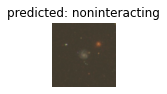

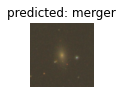

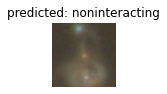

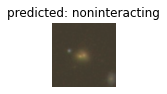

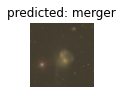

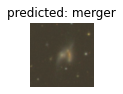

In [23]:
visualize_model(model_conv)

plt.ioff()
plt.show()

In [24]:
# Testing loop
test_loader = dataloaders["test"]
correct, total = 0, 0

all_preds = []
all_targets = []
outs = []

model_conv.eval()  # Set model to evaluation mode.
with torch.no_grad():
  
  # Iterate over the test data and generate predictions
  for i, data in enumerate(test_loader, 0):
    
    # Get inputs
    inputs, targets = data

    inputs = inputs.to(device)
    targets = targets.to(device)
    
    # Generate outputs
    outputs = model_conv(inputs)
    
    # Set total and correct
    _, predicted = torch.max(outputs.data, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    all_preds.append(predicted)
    all_targets.append(targets)
    outs.append(outputs.data)
    
  # Print accuracy
  print(f"Accuracy: {100 * correct / total}")

Accuracy: 78.26413206603301


In [25]:
print(f"Accuracy: {correct/total}")

Accuracy: 0.7826413206603302


In [26]:
for pred in all_preds:
  pred = pred.cpu().numpy()

In [27]:
preds = np.hstack([pred.cpu().numpy() for pred in all_preds])
targets_ = np.hstack([target_.cpu().numpy() for target_ in all_targets])

In [28]:
!pip install plot-metric

In [29]:
from plot_metric.functions import BinaryClassification

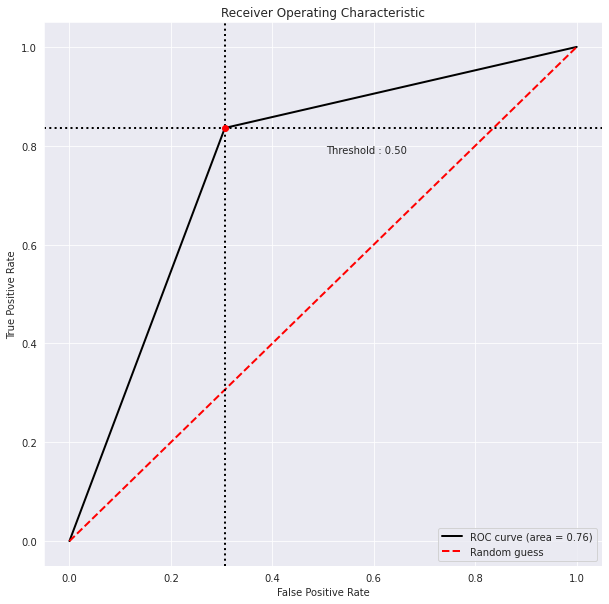

In [30]:
# Visualisation with plot_metric
bc = BinaryClassification(targets_, preds, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()

In [31]:
from sklearn.metrics import confusion_matrix

In [32]:
conf_matrix = confusion_matrix(targets_, preds)
print(conf_matrix)

[[1039  459]
 [ 410 2090]]


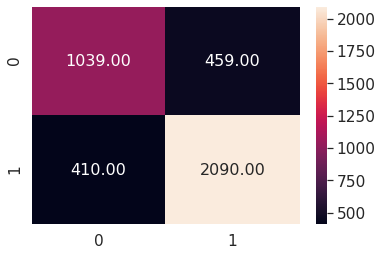

In [33]:
import pandas as pd
import seaborn as sns

df_cm = pd.DataFrame(conf_matrix, range(2), range(2))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".2f") # font size

plt.show()

In [58]:
from sklearn.metrics import precision_score, recall_score, f1_score

In [59]:
precision = precision_score(targets_, preds, average='binary')
recall = recall_score(targets_, preds, average='binary')
f1_score = f1_score(targets_, preds, average='binary')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")

Precision: 0.8199293840721852
Recall: 0.836
F1 Score: 0.8278867102396514


In [34]:
outs_last_excluded = np.hstack([out.cpu().numpy() for out in outs[:-1]])

In [35]:
final_outs = np.hstack([ans for ans in outs_last_excluded])

In [36]:
outs = [out.cpu().numpy() for out in outs]

In [37]:
answer = [np.hstack(outs[i][:, 0]) for i in range(len(outs))]

In [38]:
class_1_raw_preds = np.hstack([ans for ans in answer])

In [39]:
answer2 = [np.hstack(outs[i][:, -1]) for i in range(len(outs))]

In [40]:
class_2_raw_preds = np.hstack([ans for ans in answer2])

In [41]:
class_22_raw_preds = 1 - class_2_raw_preds

In [42]:
# c1 = np.abs(class_1_raw_preds)
# c2 = np.abs(class_2_raw_preds)

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

# hist_style_all = dict(histtype="step", color="darkgreen", label="All")
# hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
# hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# # ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# # ax1.set_xlabel("Prediction", fontsize=16);
# # ax1.set_ylabel("", fontsize=16);
# # ax1.set_title("Individual predictions (both)");
# # ax1.legend(frameon=False);

# ax[0].hist(c1[targets_.astype(bool)], bins=np.linspace(0, 1, 50),
#         **hist_style_class1);
# ax[0].hist(c2[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
#         **hist_style_class2);

# ax[0].set_xlabel("Prediction", fontsize=16);
# ax[0].set_ylabel("", fontsize=16);
# ax[0].set_title("Individual predictions (both)")
# ax[0].legend(frameon=False);

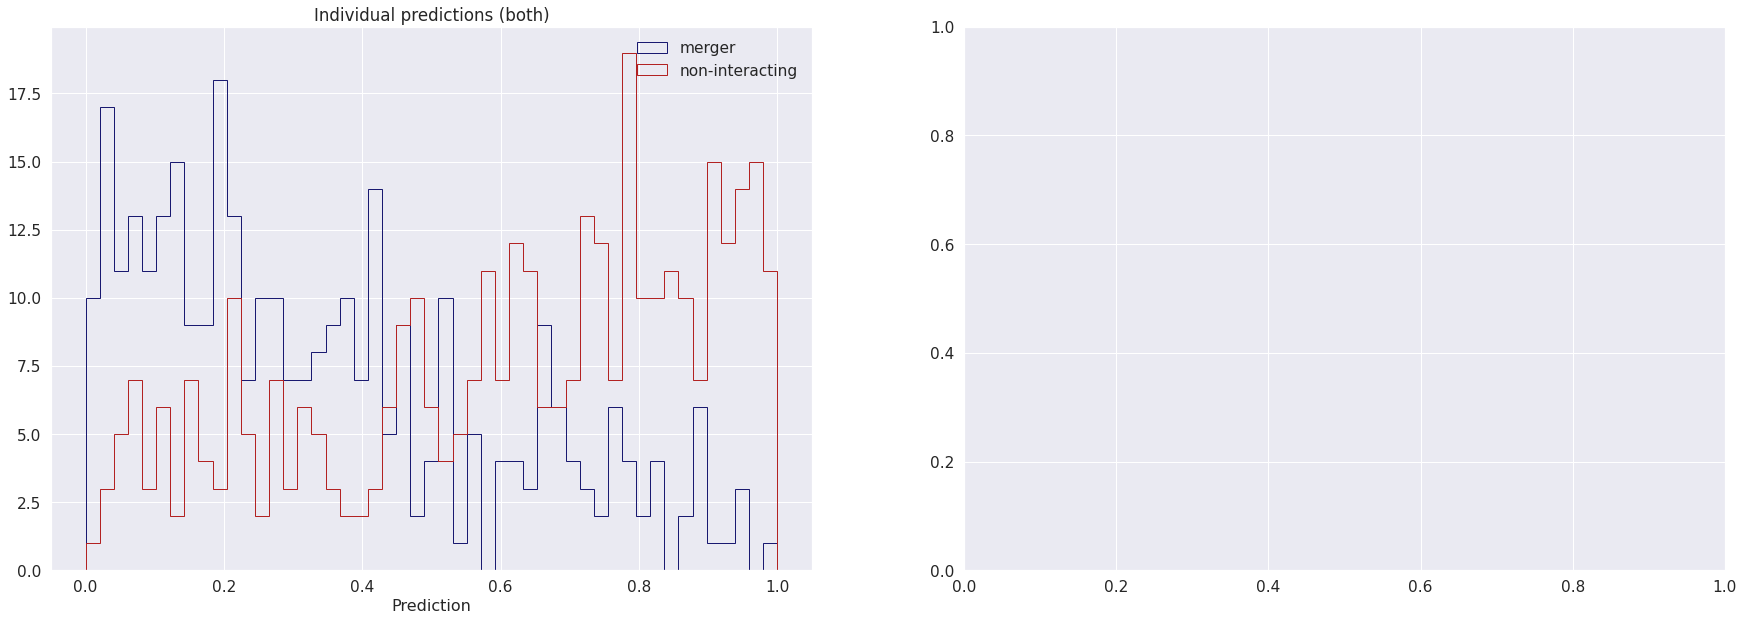

In [43]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 10));

hist_style_all = dict(histtype="step", color="darkgreen", label="All")
hist_style_class1 = dict(histtype="step", color="midnightblue", label="merger")
hist_style_class2 = dict(histtype="step", color="firebrick", label="non-interacting")

# ax1.hist(preds, bins=np.linspace(0, 1, 50), **hist_style_all);

# ax1.set_xlabel("Prediction", fontsize=16);
# ax1.set_ylabel("", fontsize=16);
# ax1.set_title("Individual predictions (both)");
# ax1.legend(frameon=False);

ax[0].hist(class_1_raw_preds[targets_.astype(bool)], bins=np.linspace(0, 1, 50),
        **hist_style_class1);
ax[0].hist(class_22_raw_preds[~(targets_.astype(bool))], bins=np.linspace(0, 1, 50),
        **hist_style_class2);

ax[0].set_xlabel("Prediction", fontsize=16);
ax[0].set_ylabel("", fontsize=16);
ax[0].set_title("Individual predictions (both)")
ax[0].legend(frameon=False);

In [44]:
!ls dataset_zurich/test/merger | wc -l

1498


In [45]:
!ls dataset_zurich/test/noninteracting | wc -l

2500


In [46]:
!ls dataset_zurich/train/merger | wc -l

3003


In [47]:
!ls dataset_zurich/train/noninteracting | wc -l

5000


In [48]:
!ls dataset_zurich/val/merger | wc -l

1499


In [49]:
!ls dataset_zurich/val/noninteracting | wc -l

2500
